### **This notebook is used to generate brain tumor segmentation using UNet**

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nilearn


     |████████████████████████████████| 3.1MB 8.6MB/s 


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation ,Dropout
from keras.layers.convolutional import Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
import pickle
import skimage.transform as skTrans
from nilearn import image
from nilearn.image import resample_img
import nibabel.processing
import warnings
import scipy
%matplotlib inline
import seaborn as sns
from scipy.ndimage import rotate
import random

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


### **Data-Preprocessing**

In [ ]:
# join the directory and paths
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MRI Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/MRI Data/seg.nii.gz
/content/drive/MyDrive/MRI Data/flair.nii
/content/drive/MyDrive/MRI Data/fig.png
/content/drive/MyDrive/MRI Data/Output000.png
/content/drive/MyDrive/MRI Data/Output001.png
/content/drive/MyDrive/MRI Data/Output003.png
/content/drive/MyDrive/MRI Data/Output004.png
/content/drive/MyDrive/MRI Data/Output002.png
/content/drive/MyDrive/MRI Data/Output006.png
/content/drive/MyDrive/MRI Data/Output005.png
/content/drive/MyDrive/MRI Data/Output008.png
/content/drive/MyDrive/MRI Data/Output009.png
/content/drive/MyDrive/MRI Data/Output007.png
/content/drive/MyDrive/MRI Data/Output011.png
/content/drive/MyDrive/MRI Data/Output010.png
/content/drive/MyDrive/MRI Data/Output012.png
/content/drive/MyDrive/MRI Data/Output013.png
/content/drive/MyDrive/MRI Data/Output014.png
/content/drive/MyDrive/MRI Data/Output016.png
/content/drive/MyDrive/MRI Data/Output015.png
/content/drive/MyDrive/MRI Data/Output017.png
/content/drive/MyDrive/MRI Data/Output018.png
/

In [ ]:
"""
rescale_Nii(nifti_file):
This function takes a .nii files as an input and rescales it according to the 
values of voxel_dims by creating a new affine transform. The new affine transform
is used in resample_img() function from nibable library which will transform the images
accordinly inputs for resample_img() are tagert image, target affine transform and target shape

Input:
nifti_file: A .nii file which we want to rescale

Output:
rescaled .nii file with dimensions as defined in target_shape
"""


def rescale_Nii(nifti_file):
    warnings.filterwarnings("ignore")
    img=nifti_file
    #voxel_dims=[3.8, 3.8,1]
    voxel_dims=[1.60, 1.60,1]
    

    
    #target_shape=(64,64,130)
    # downlsample to 128*128*155
    target_shape=(128,128,130)

    # Initialize target_affine
    target_affine = img.affine.copy()
    # Calculate the translation part of the affine
    spatial_dimensions = (img.header['dim'] * img.header['pixdim'])[1:4]
    
    # Calculate the translation affine as a proportion of the real world
    # spatial dimensions
    image_center_as_prop = img.affine[0:3,3] / spatial_dimensions
    
    # Calculate the equivalent center coordinates in the target image
    dimensions_of_target_image = (np.array(voxel_dims) * np.array(target_shape))
    target_center_coords =  dimensions_of_target_image * image_center_as_prop
    # Decompose the image affine to allow scaling
    u,s,v = np.linalg.svd(target_affine[:3,:3],full_matrices=False)
    
    # Rescale the image to the appropriate voxel dimensions
    s = voxel_dims
    
    # Reconstruct the affine
    target_affine[:3,:3] = u @ np.diag(s) @ v

    # Set the translation component of the affine computed from the input
    target_affine[:3,3] = target_center_coords 
  

    #target_affine = rescale_affine(target_affine,voxel_dims,target_center_coords)
    resampled_img = resample_img(img, target_affine=target_affine,target_shape=target_shape)
    resampled_img.header.set_zooms((np.absolute(voxel_dims)))
    return resampled_img

"""
Data_Preprocessing(modalities_dir):

This function takes the images from each modality and outputs a fused image based on their average

Input:
modalities_dir: List of all the modalities present in the dataset.

Output:
P_Data: nummpy array with fused images made from all the modalities

"""

def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:   
        #load .nii file
        nifti_file   = nib.load(modality)
        # rescale .nii file
        nifti_file= rescale_Nii(nifti_file)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    #create an array to hold information about all the modalities 
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    avg_modality=[]
    for i in range(len(all_modalities)):
      # fuse image with their avg 
      x=(all_modalities[i,:,:,0]+all_modalities[i,:,:,1]+all_modalities[i,:,:,2]+all_modalities[i,:,:,3])/4
      avg_modality.append(x)  
    gt=all_modalities[:,:,:,4]
    #append fused imgage with labelled segmentation to create one array
    P_Data=np.stack(np.stack((avg_modality, gt), axis = -1))
    #P_Data=np.stack(np.stack((avg_modality), axis = -1))#for validation dataset 
    
    

    return P_Data

"""
Rand(start,end,num):
Function to generate random int.
Input:
start: starting point for range of the generator
end:   end point for range of the generator
num:  number of random int to generate from a given range of [start,end]

Output:
array of int containing random int, length of the array equals value of "num"
"""
def Rand(start, end, num):
    res = []
  
    for j in range(num):
        res.append(random.randint(start, end))
  
    return res

"""
Data_Concatenate(Input_Data):
Converts a numpy array with fused images ( eg: (20, 130, 128, 128, 2)) 
into an array with two partitions(eg: (2, 2600, 128, 128, 1)).

Input:
Input_Data= Array which contains information of all the modalities

Output:
Fused array which will used for making the training and testing split

"""

def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(2):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):

            if (counter < len(Input_Data)-1):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if (counter==0):
                    c= np.concatenate((a, b), axis=0)
                    #print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
            
            if (counter == len(Input_Data)-1):
              a= Input_Data[counter][:,:,:,i]
              c= np.concatenate((c, a), axis=0)
              print('c2={}'.format(c.shape))
              counter=counter+2

        print('c2={}'.format(c.shape))
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [ ]:
"""
translte(img,shift,direction,roll):
generate translated image as per the parameters defined.

Input:
img: target image whose translation is to be done
shift: number of units the translation should take place ,default=10
direction: direction of the translation 
roll: roll the upper slice of the image, default=ture

Output:
img: translated image in given direction with given shift
"""
def translate(img, shift=10, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up']
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img

"""
rotate(img,angle,bg_patch):
Function to perfrom image rotation of a given input image.

Input:
img: target image whose translation is to be done
angle: the angle at which image need to be rotated
bg_patch: background patch, default=(5,5)

Output:
img: rotated image in given angle
"""
def rotate_img(img, angle, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

"""
gaussian_noise(img,mean,sigma):
Function to add gaussian noise to a given input image.

Input:
img: target image whose translation is to be done
mean: the mean used to generate the noise, default= 0
sigma: the ammount of nosie to be added to the image 

Output:
img: output image contains noise as defined by the value of sigma
"""
def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img

"""
show_img(), plot_grid() functions to display images in a grid pattern
"""   
def show_img(img, ax):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
   
def plot_grid(imgs, nrows, ncols, figsize=(10, 10)):
    assert len(imgs) == nrows*ncols, f"Number of images should be {nrows}x{ncols}"
    _, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        show_img(img, ax)



In [ ]:

# load the image path
Path= '/content/drive/MyDrive/MRI Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
# for validation dataset 
#Path='/content/drive/MyDrive/MRI Data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
p=os.listdir(Path)
Input_Data= []

# for images in range of p generate a numpy array with fused data
for i in p[300:369]:
  
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    #modalities_dir = [flair[0], t1[0], t1ce[0], t2[0]] # for validation dataset 
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)
    


In [ ]:
# save the generated input data to google drive for future use using pickle library
"""
for i in range(0,369,100):# pickle data in partition
  print("/content/drive/MyDrive/MRI Data/Partitioned/{}-{}".format(i,i+100))
  filename="/content/drive/MyDrive/MRI Data/Partitioned/{}-{}".format(i,i+100)
  with open(filename+'.pkl','wb') as f:
    pickle.dump(Input_Data[i:i+100],f)
"""

In [ ]:
#unpickle data
with open('/content/drive/MyDrive/MRI Data/Partitioned/300-400.pkl', 'rb') as f:
   Input_Data=pickle.load(f)

In [ ]:
# call data concatenate function
InData= Data_Concatenate(Input_Data)

$
c2=(520, 128, 128)
c2=(780, 128, 128)
c2=(1040, 128, 128)
c2=(1300, 128, 128)
c2=(1560, 128, 128)
c2=(1820, 128, 128)
c2=(2080, 128, 128)
c2=(2340, 128, 128)
c2=(2600, 128, 128)
c2=(2860, 128, 128)
c2=(3120, 128, 128)
c2=(3380, 128, 128)
c2=(3640, 128, 128)
c2=(3900, 128, 128)
c2=(4160, 128, 128)
c2=(4420, 128, 128)
c2=(4680, 128, 128)
c2=(4940, 128, 128)
c2=(5200, 128, 128)
c2=(5460, 128, 128)
c2=(5720, 128, 128)
c2=(5980, 128, 128)
c2=(6240, 128, 128)
c2=(6500, 128, 128)
c2=(6760, 128, 128)
c2=(7020, 128, 128)
c2=(7280, 128, 128)
c2=(7540, 128, 128)
c2=(7800, 128, 128)
c2=(8060, 128, 128)
c2=(8320, 128, 128)
c2=(8580, 128, 128)
c2=(8840, 128, 128)
c2=(8970, 128, 128)
c2=(8970, 128, 128)
$
c2=(520, 128, 128)
c2=(780, 128, 128)
c2=(1040, 128, 128)
c2=(1300, 128, 128)
c2=(1560, 128, 128)
c2=(1820, 128, 128)
c2=(2080, 128, 128)
c2=(2340, 128, 128)
c2=(2600, 128, 128)
c2=(2860, 128, 128)
c2=(3120, 128, 128)
c2=(3380, 128, 128)
c2=(3640, 128, 128)
c2=(3900, 128, 128)
c2=(4160, 128, 128)


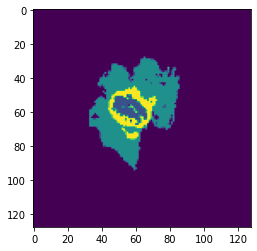

In [ ]:
img=InData[1][69,:,:,0]
plt.imshow(img)

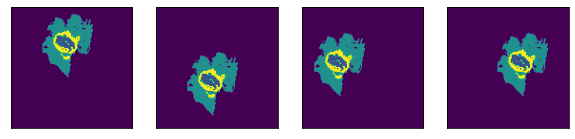

In [ ]:
plot_grid([translate(img, direction='up', shift=20),
           translate(img, direction='down', shift=20), 
           translate(img, direction='left', shift=20),
           translate(img, direction='right', shift=20)],
           1, 4, figsize=(10, 5))

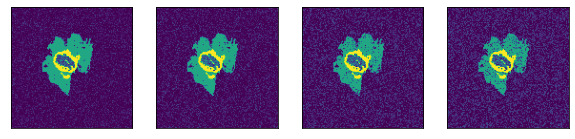

In [ ]:
plot_grid([gaussian_noise(img, sigma=0.40),
           gaussian_noise(img ,sigma=0.50), 
           gaussian_noise(img, sigma=0.80),
           gaussian_noise(img, sigma=1)],
           1, 4, figsize=(10, 5))

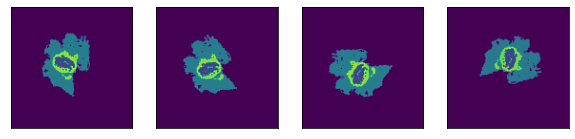

In [ ]:
plot_grid([rotate_img(img, angle=10),
           rotate_img(img, angle=50), 
           rotate_img(img, angle=100),
           rotate_img(img, angle=295)],
           1, 4, figsize=(10, 5))

In [ ]:
# generate index at random on which image augmentation will take place
random.seed(2020)
direction=['up','down','left','right']
sigma=[0.40,0.50,0.60,0.70]
angle=[10,15,20,25]
shift=10
#get index for 20% of the dataset
index=(Rand(0, len(InData[0]), int(len(InData[0])*0.20)))

In [ ]:
for i in index:
  for j in range(2):
    # data augmentation
    Augmented=translate(InData[j][i-1,:,:,0],shift,direction=direction[random.randint(0,3)])
    Augmented=gaussian_noise(Augmented,sigma[random.randint(0,3)])
    Augmented=rotate_img(Augmented,angle[random.randint(0,3)])
    InData[j][i-1,:,:,0]=Augmented

### **Model** **Training**

In [ ]:
def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model
# Loding the Light weighted CNN
model = model(input_shape = (128,128,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# create train test split 85/15
AIO= concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,0],dtype='float32')
TRL=np.array(AIO[:,:,:,1],dtype='float32')#segmentation
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
AIO=0

In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2* intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)/100
 

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Compiling the model 
Adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

In [ ]:
# Fitting the model over the data
history = model.fit(X_train,Y_train,batch_size=32,epochs=200,validation_split=0.20,verbose=1,initial_epoch=160)

Epoch 161/200
191/191 [==============================] - 32s 72ms/step - loss: -0.2527 - accuracy: 0.9854 - dice_coef: 0.7924 - precision: 0.9328 - sensitivity: 0.9719 - specificity: 0.9984 - val_loss: -0.2530 - val_accuracy: 0.9830 - val_dice_coef: 0.7685 - val_precision: 0.8564 - val_sensitivity: 0.9749 - val_specificity: 0.9964
Epoch 162/200
191/191 [==============================] - 12s 64ms/step - loss: -0.2557 - accuracy: 0.9854 - dice_coef: 0.7950 - precision: 0.9375 - sensitivity: 0.9746 - specificity: 0.9986 - val_loss: -0.2549 - val_accuracy: 0.9827 - val_dice_coef: 0.7559 - val_precision: 0.8587 - val_sensitivity: 0.9514 - val_specificity: 0.9965
Epoch 163/200
191/191 [==============================] - 12s 64ms/step - loss: -0.2532 - accuracy: 0.9856 - dice_coef: 0.7985 - precision: 0.9396 - sensitivity: 0.9751 - specificity: 0.9986 - val_loss: -0.2594 - val_accuracy: 0.9838 - val_dice_coef: 0.7755 - val_precision: 0.8934 - val_sensitivity: 0.9673 - val_specificity: 0.9974
E

In [ ]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)


239/239 [==============================] - 5s 20ms/step - loss: -0.2627 - accuracy: 0.9855 - dice_coef: 0.8022 - precision: 0.9485 - sensitivity: 0.9661 - specificity: 0.9988


[-0.26267901062965393,
 0.9855031371116638,
 0.8021770119667053,
 0.9484544992446899,
 0.966071367263794,
 0.9988197088241577]

In [ ]:
#save the model for future use 
model.save('/content/drive/MyDrive/MRI Data/Model_History/BraTs2020_(Fused_0-369).h5')

In [ ]:
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

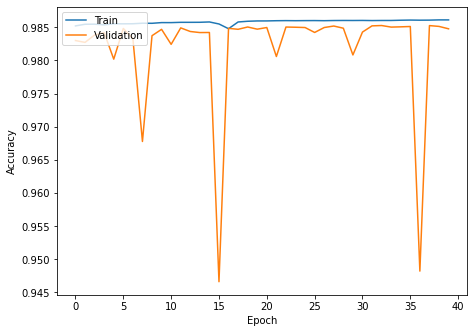

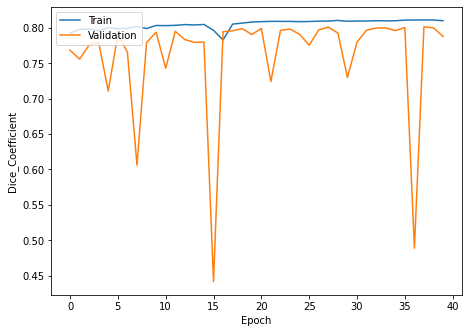

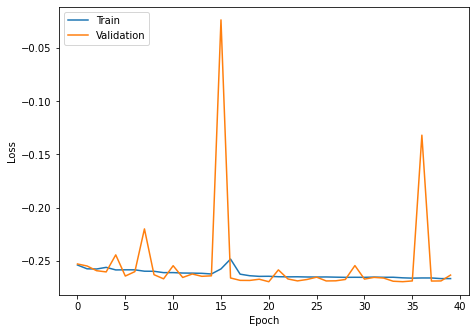

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

### **Checking Predictions**

In [ ]:
#load model weights 
model.load_weights('/content/drive/MyDrive/MRI Data/Model_History/BraTs2020_(Fused_0-369).h5')

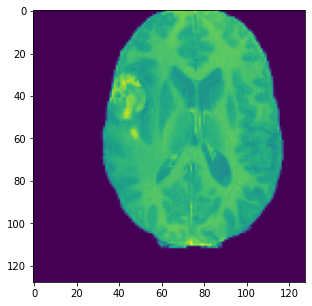

In [ ]:
#Original Image
fig = plt.figure(figsize=(5,5))
immmg = X_test[699,:,:]
imgplot = plt.imshow(immmg)
plt.show()

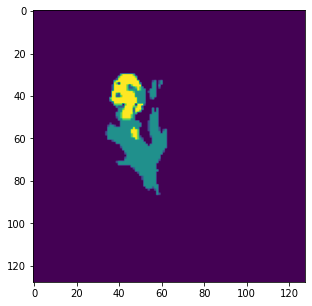

In [ ]:
#True Label
fig = plt.figure(figsize=(5,5))
immmg = Y_test[699,:,:]
imgplot = plt.imshow(immmg)
plt.show()

In [ ]:
#predict tumor
pref_Tumorrr = model.predict(X_test)

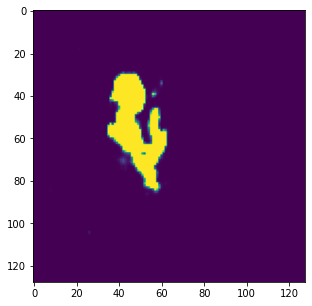

In [ ]:
#Predicted Label
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumorrr[699,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

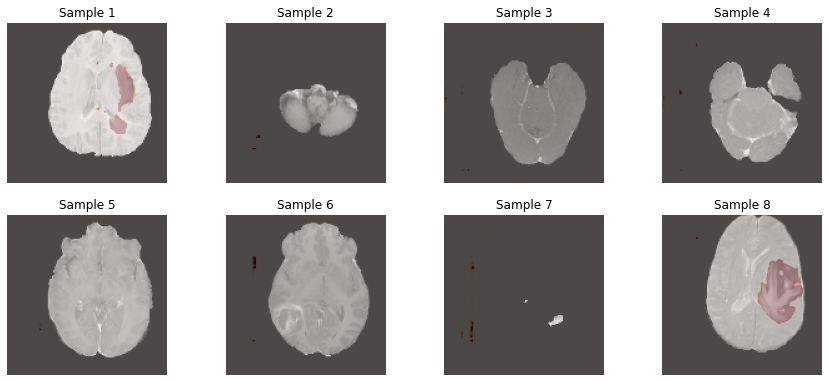

In [ ]:
x=800
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+70,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+70,:,:,0]),alpha=0.3,cmap='Reds')


plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+75,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+75,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+80,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+80,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+85,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+85,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+90,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+95,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+100,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+105,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+115,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+115,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(X_test[x+120,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumorrr[x+120,:,:,0]),alpha=0.3,cmap='Reds')
